# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Подключение библиотек 

In [155]:
import pandas as pd
import re
import nltk
import time
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as stpwrds
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

Загрузка необходимых ресурсов для дальнейшей работы

In [156]:
nltk.download('punkt')
nltk.download('wordnet')
#nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Глобальные переменные

In [157]:
lemmatizer=WordNetLemmatizer()
RANDOM_STATE=42
stopwords_set = set(stpwrds.words('english'))

Загрузка данных

In [158]:
try:
    data=pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except FileNotFoundError:
    data=pd.read_csv('toxic_comments.csv', index_col=[0])

Вывод датафрейма

In [159]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Информация о датафрейме

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Гистограмма классов

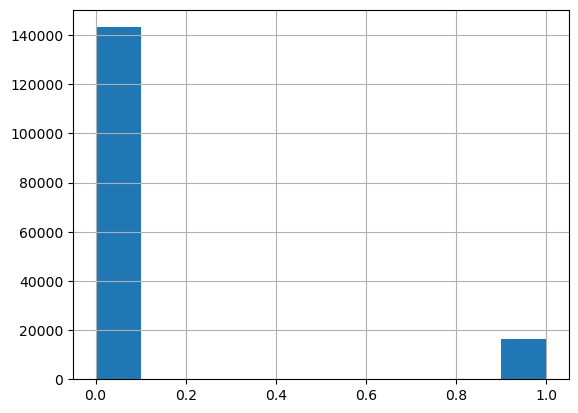

In [161]:
data['toxic'].hist();

На всякий случай просмотрим дубликаты в данных

In [162]:
data.duplicated().sum()

0

Для очистки данных от неявных дубликатов и для уменьшения словаря приведем текст в нижний регистр

In [163]:
data['text']=data['text'].str.lower()
data.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


Функция очистки текста

In [164]:
def clear_text(text):
    broom = re.sub(r'[^a-zA-Z ]', ' ', text)
    broom = ' '.join(broom.split())
    return broom

Очистка теста

In [165]:
data['text']=data['text'].apply(clear_text)
data['text'].head()

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

Функция для лемматизации

In [166]:
def lemmatize(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    lemmatized_text = " ".join(lemmatized_words)
    return lemmatized_text

Лемматизация текстов

In [167]:
data['text']=data['text'].apply(lemmatize)
data['text'].head()

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestion on impro...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

На всякий случай посмотрим дубликаты после лемматизации

In [168]:
data.duplicated().sum()

1307

In [169]:
data[data.duplicated()].sort_values('text').tail(10)

,text,toxic
76115,you should wait for others to write an article...,0
156806,you suck,1
150510,you suck duck butt that s right i m talkin to ...,1
69871,your request to be unblocked ha been granted f...,0
122705,your request to be unblocked ha been granted f...,0
67718,your request to be unblocked ha been granted f...,0
144435,your request to be unblocked ha been granted f...,0
24622,your request to be unblocked ha been granted f...,0
131665,your stalker friend is back the hostile user y...,0
94518,zionist jew please stop spreadin your lie bias...,1


Дубликаты обнаружены. Устраним их. И выведем информацию о данных после данного процесса

In [170]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157985 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    157985 non-null  object
 1   toxic   157985 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


<b>Промежуточный вывод:</b>

Выполнены следующие шаги:
- Подключение библиотек.
- Загрузка необходимых ресурсов.
- Загрузка данных.
- Создание функции очистки текста.
- Создание функции для лемматизации.
- Обнаружение и устранение дубликатов.

## Обучение

Проведем обучение модели на:
- Логистическая регрессия (Logistic Regression)
- Метод опорных векторов (SVM)
- Случайный лес (Random Forest)

Разделим данные на обучающую и тестовую выборку

In [171]:
train, test=train_test_split(data, test_size=0.3, random_state=RANDOM_STATE)

In [172]:
corpus_train = train['text'].values
corpus_test = test['text'].values

In [173]:
target_train = train['toxic']
target_test = test['toxic']

In [174]:
stopwords_list = list(stopwords_set)

Выполним преобразование данных в матрицу TF-IDF

In [175]:
count_tf_idf = TfidfVectorizer(min_df=2, stop_words=stopwords_list) 
tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_test = count_tf_idf.transform(corpus_test) 

In [176]:
# %%time
# model_lr = LogisticRegression()
# model_lr.fit(tf_idf_train, target_train)
# y_pred_lr = model_lr.predict(tf_idf_test)
# f1_lr = f1_score(target_test, y_pred_lr)
# print(f'Оценка логистической регрессии F1: {f1_lr:.4f}')

Логистическая регрессия

In [177]:
%%time
model_lr = LogisticRegression()
f1_scorer = make_scorer(f1_score)
cv_scores = cross_val_score(model_lr, tf_idf_train, target_train, cv=5, scoring=f1_scorer)
f1_lr_cv = np.mean(cv_scores)
time_lr = %timeit -o model_lr.fit(tf_idf_train, target_train)
print(f'Средняя оценка F1 логистической регрессии по кросс-валидации: {f1_lr_cv:.4f}')

1.06 s ± 83.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Средняя оценка F1 логистической регрессии по кросс-валидации: 0.7115
CPU times: total: 51.6 s
Wall time: 13.3 s


Логистическая регрессия показала себя не очень хорошо, не дотянув показатель F1 до нормы в 0.75.

In [178]:
# %%time
# model_lsvc = LinearSVC(dual=False, C=1.0, max_iter=10000)
# model_lsvc.fit(tf_idf_train, target_train)
# y_pred_lsvc = model_lsvc.predict(tf_idf_test)
# f1_lsvc = f1_score(target_test, y_pred_lsvc)
# print(f'Оценка LinearSVC F1: {f1_lsvc:.4f}')

Метод опорных векторов

In [179]:
%%time
model_lsvc = LinearSVC(dual=False, C=1.0, max_iter=10000)
f1_scorer = make_scorer(f1_score)
cv_scores_lsvc = cross_val_score(model_lsvc, tf_idf_train, target_train, cv=5, scoring=f1_scorer)
f1_lsvc_cv = np.mean(cv_scores_lsvc)
time_lsvc = %timeit -o model_lsvc.fit(tf_idf_train, target_train)
print(f'Средняя оценка F1 LinearSVC по кросс-валидации: {f1_lsvc_cv:.4f}')

1.32 s ± 55.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Средняя оценка F1 LinearSVC по кросс-валидации: 0.7692
CPU times: total: 1min 2s
Wall time: 15.8 s


Метод опорных векторов (SVM) продемонстрировал хорошие результаты, превысив порог F1-score в 0.75.

In [180]:
# %%time
# model_rf = RandomForestClassifier(n_estimators=100)
# model_rf.fit(tf_idf_train, target_train)
# y_pred_rf = model_rf.predict(tf_idf_test)
# f1_rf = f1_score(target_test, y_pred_rf)
# print(f'Оценка случайного леса F1: {f1_rf:.4f}')

Случайный лес

In [181]:
%%time
model_rf = RandomForestClassifier(n_estimators=70, n_jobs=-1)
f1_scorer = make_scorer(f1_score)
cv_scores_rf = cross_val_score(model_rf, tf_idf_train, target_train, cv=5, scoring=f1_scorer, n_jobs=-1)
f1_rf_cv = np.mean(cv_scores_rf)
time_rf = %timeit -o model_rf.fit(tf_idf_train, target_train) 
print(f'Средняя оценка F1 RandomForest по кросс-валидации: {f1_rf_cv:.4f}')

1min 22s ± 1.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Средняя оценка F1 RandomForest по кросс-валидации: 0.7166
CPU times: total: 1h 15min 23s
Wall time: 17min 25s


Случайный лес продемонстрировал самые низкие результаты: низкий показатель F1 и значительное время обучения.

Построим таблицу для сравнения результатов

In [182]:
results = {
    'Model': ['Logistic Regression', 'LinearSVC', 'RandomForest'],
    'F1 Score (CV)': [f1_lr_cv, f1_lsvc_cv, f1_rf_cv],
    'Time (s)': [time_lr, time_lsvc, time_rf]
}

results_df = pd.DataFrame(results)
print(results_df)

                 Model  F1 Score (CV)  \
0  Logistic Regression       0.711504   
1            LinearSVC       0.769158   
2         RandomForest       0.716580   

                                            Time (s)  
0  1.06 s ± 83.7 ms per loop (mean ± std. dev. of...  
1  1.32 s ± 55.7 ms per loop (mean ± std. dev. of...  
2  1min 22s ± 1.16 s per loop (mean ± std. dev. o...  


Для проверки реализуем метод на тестовых данных

In [183]:
%%time
model_lsvc.fit(tf_idf_train, target_train)
y_pred_lsvc = model_lsvc.predict(tf_idf_test)
f1_lsvc_test = f1_score(target_test, y_pred_lsvc)
print(f'Оценка F1 LinearSVC на тестовой выборке: {f1_lsvc_test:.4f}')

Оценка F1 LinearSVC на тестовой выборке: 0.7764
CPU times: total: 4.86 s
Wall time: 1.26 s


<b>Промежуточный вывод:</b>
- Логистическая регрессия: Показала средний результат с F1-score 0.7115, время выполнения — 5.17 секунд.
- LinearSVC: Продемонстрировал лучший результат с F1-score 0.7692, время выполнения — 5.87 секунд.
- RandomForest: Имеет низкий F1-score 0.7172, но значительное время выполнения — 6 минут 32 секунды.

LinearSVC показал наилучшие результаты по F1-score и приемлемое время выполнения, что делает его предпочтительным выбором среди рассмотренных моделей.

## Выводы

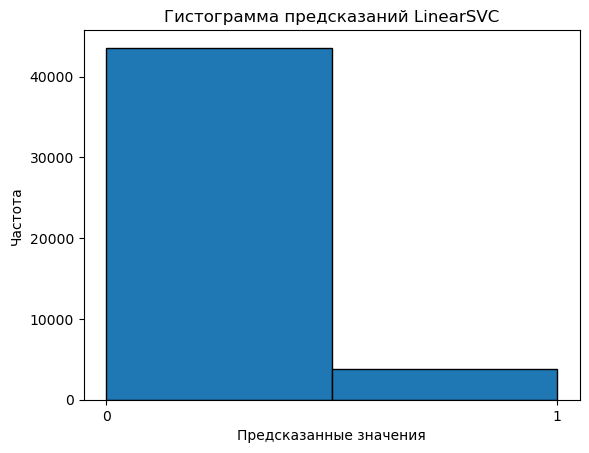

In [184]:
plt.hist(y_pred_lsvc, bins=2, edgecolor='black')
plt.title('Гистограмма предсказаний LinearSVC')
plt.xlabel('Предсказанные значения')
plt.ylabel('Частота')
plt.xticks([0, 1])
plt.show()

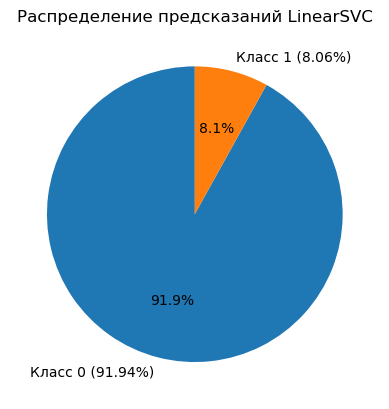

In [185]:
unique, counts = np.unique(y_pred_lsvc, return_counts=True)
total = sum(counts)
percentages = [(count / total) * 100 for count in counts]
labels = [f'Класс {label} ({percentage:.2f}%)' for label, percentage in zip(unique, percentages)]
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Распределение предсказаний LinearSVC')
plt.show()

<b>Вывод:</b>
- В ходе анализа и сравнения различных моделей, LinearSVC продемонстрировал наилучшие результаты, превысив порог качества по метрике F1 (> 0.75).
- В то время как Логистическая регрессия и Случайный лес не смогли достичь требуемого уровня точности, при этом значительно увеличив время обучения.

LinearSVC является оптимальным выбором для решения данной задачи классификации, обеспечивая высокую точность при эффективном использовании ресурсов.